In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import seaborn as sns

In [4]:
# File path
file_path = r"C:\Users\adnan\OneDrive\Documents\Complexity_Shokkom_Sharma\relu\meta_data.csv"
spike_data = pd.read_csv(file_path)

# Function to process dataset
def process_dataset(df, column_name):
    data = df[[column_name, df.columns[df.columns.get_loc(column_name) + 1]]].copy()
    data.columns = ['Time', 'Spike']
    data = data.iloc[1:]  # Remove the header row
    data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
    data['Spike'] = pd.to_numeric(data['Spike'], errors='coerce')
    data = data.dropna()
    data['Dataset'] = column_name
    return data

dataframes = []
for column in ['Data1', 'Data2', 'Data3', 'Data4', 'Data5']:
    if column in spike_data.columns:
        df = process_dataset(spike_data, column)
        dataframes.append(df)
    else:
        print(f"Column {column} not found in the dataset")

# Separate Data1-4 and Data5
dataframe_1 = pd.concat(dataframes[:4], ignore_index=True)  # Data1 to Data4
dataframe_2 = dataframes[4]  # Data5

In [5]:
def engineer_features(df):
    df = df.sort_values('Time')
    df['Time_Diff'] = df['Time'].diff().fillna(0)
    
    # Inter-spike intervals
    df['ISI'] = df['Time_Diff']
    
    # Coefficient of variation of ISIs
    window_size = 10
    df['CV_ISI'] = df['ISI'].rolling(window=window_size).std() / df['ISI'].rolling(window=window_size).mean()
    
    # Rolling window features
    window_sizes = [3, 5, 10]
    for size in window_sizes:
        df[f'Rolling_Mean_{size}'] = df['Spike'].rolling(window=size).mean()
        df[f'Rolling_Std_{size}'] = df['Spike'].rolling(window=size).std()
    
    # Fourier features
    for period in [5, 10, 20]:
        df[f'Sin_{period}'] = np.sin(2 * np.pi * df['Time'] / period)
        df[f'Cos_{period}'] = np.cos(2 * np.pi * df['Time'] / period)
    
    return df.fillna(0)

In [8]:
# Apply feature engineering
dataframe_1 = engineer_features(dataframe_1)
dataframe_2 = engineer_features(dataframe_2)

# Prepare features and target
feature_columns = ['Time', 'Time_Diff', 'ISI', 'CV_ISI'] + \
                  [col for col in dataframe_1.columns if col.startswith(('Rolling_', 'Sin_', 'Cos_'))]

X_train = dataframe_1[feature_columns].values
y_train = dataframe_1['Spike'].values

X_test = dataframe_2[feature_columns].values
y_test = dataframe_2['Spike'].values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the model
def create_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

# Create and compile the model
model = create_model(X_train_scaled.shape[1])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=16, 
                    validation_split=0.2, callbacks=[early_stopping, lr_scheduler], verbose=1)

# Predict on test set (Dataset 5)
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

Epoch 1/100


C:\Users\adnan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5445 - loss: 0.6894 - val_accuracy: 0.6795 - val_loss: 0.5779 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7218 - loss: 0.5808 - val_accuracy: 0.6859 - val_loss: 0.5896 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7584 - loss: 0.5357 - val_accuracy: 0.6859 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7644 - loss: 0.5230 - val_accuracy: 0.6795 - val_loss: 0.5695 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7299 - loss: 0.5358 - val_accuracy: 0.6795 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7571 - loss: 0.5289 - val_accuracy: 0.6859 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7544 - loss: 0.5099 - val_accuracy: 0.685

In [9]:
# Evaluate the model
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

Test Accuracy: 0.7041
Precision: 0.7059
Recall: 0.5581
F1-score: 0.6234


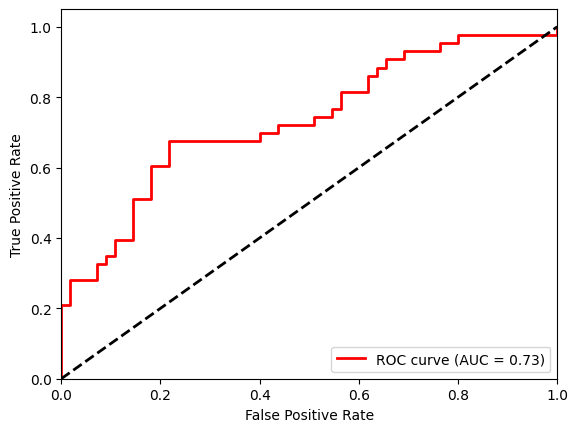

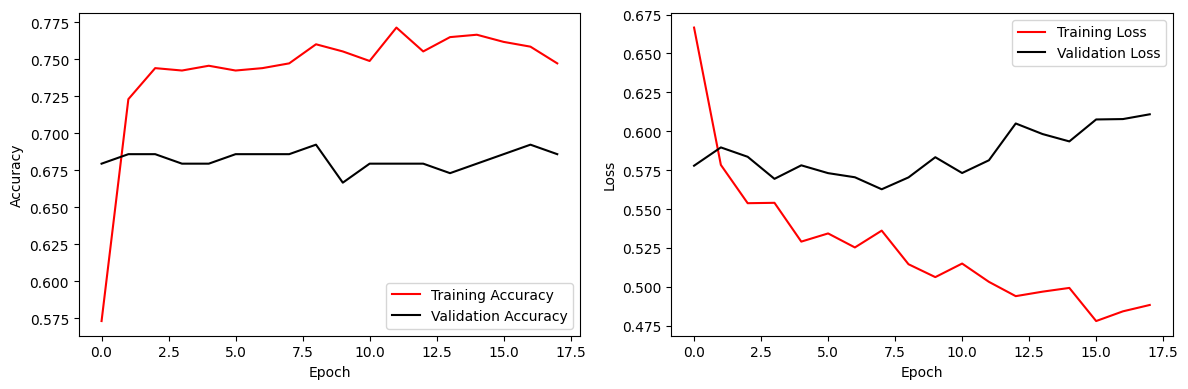

In [25]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Plot training history//[L] Model Accuracy, [R] Model loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='black', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='red', label='Training Loss')
plt.plot(history.history['val_loss'], color='black', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [11]:
# Save predictions for Dataset 5
dataframe_2['Predicted_Spike'] = y_pred
dataframe_2[['Time', 'Spike', 'Predicted_Spike']].to_csv(r"C:\Users\adnan\OneDrive\Documents\Complexity_Shokkom_Sharma\relu\dataset5_predictions.csv", index=False)

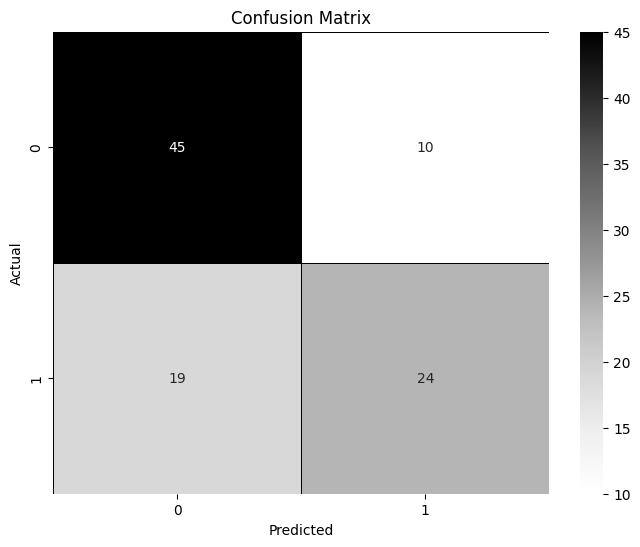


Additional Metrics:
True Positives: 24
False Positives: 10
True Negatives: 45
False Negatives: 19
Accuracy: 0.7041
Precision: 0.7059
Recall: 0.5581
F1 Score: 0.6234


In [21]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', cbar=True, linecolor='black', linewidths=0.5)
plt.title('Confusion Matrix', color='black')
plt.xlabel('Predicted', color='black')
plt.ylabel('Actual', color='black')
plt.show()

# Calculate and print additional metrics
true_positives = ((dataframe_2['Spike'] == 1) & (dataframe_2['Predicted_Spike'] == 1)).sum()
false_positives = ((dataframe_2['Spike'] == 0) & (dataframe_2['Predicted_Spike'] == 1)).sum()
true_negatives = ((dataframe_2['Spike'] == 0) & (dataframe_2['Predicted_Spike'] == 0)).sum()
false_negatives = ((dataframe_2['Spike'] == 1) & (dataframe_2['Predicted_Spike'] == 0)).sum()

print("\nAdditional Metrics:")
print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")
print(f"Accuracy: {(true_positives + true_negatives) / len(dataframe_2):.4f}")
print(f"Precision: {true_positives / (true_positives + false_positives):.4f}")
print(f"Recall: {true_positives / (true_positives + false_negatives):.4f}")
print(f"F1 Score: {2 * true_positives / (2 * true_positives + false_positives + false_negatives):.4f}")